In [ ]:
import matplotlib.pyplot as plt
# from matplotlib.path import Path
# https://matplotlib.org/stable/api/path_api.html
# from matplotlib.patches import PathPatch

import numpy as np

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from shapely.geometry import LinearRing
import shapely
from shapely import affinity

from BFS_erebus_oh import Obstacle, Project2Map

import math

from tqdm import tqdm

map = Project2Map()

# o = Obstacle(xs, ys, clearance=2)
# o = LinearRing(pts)

# print(o.is_closed)

# test = [20, 18.5]
test = [30, 10]
# ax.fill(*o.xy)

# ax.plot(test[0], test[1], marker='o', color='pink')

# o.draw(ax)

# letter_e.draw(ax, color='blue')

# # ax.fill(*letter_e.plot_points(), facecolor='blue')

# ax.plot(test[0], test[1], marker='o', color='pink')

# letter_e.collides(test)
# p = Point(test)


# whether points is +/- 2 mm from boundary
# print(o.dwithin(p, 2))
# # whether point is inside
# ßprint(Polygon(o).contains(p))

map.map(0, 0)

# BFS Code

`BFS_erebus_oh.py`

solved
Solution: 41


ValueError: too many values to unpack (expected 2)

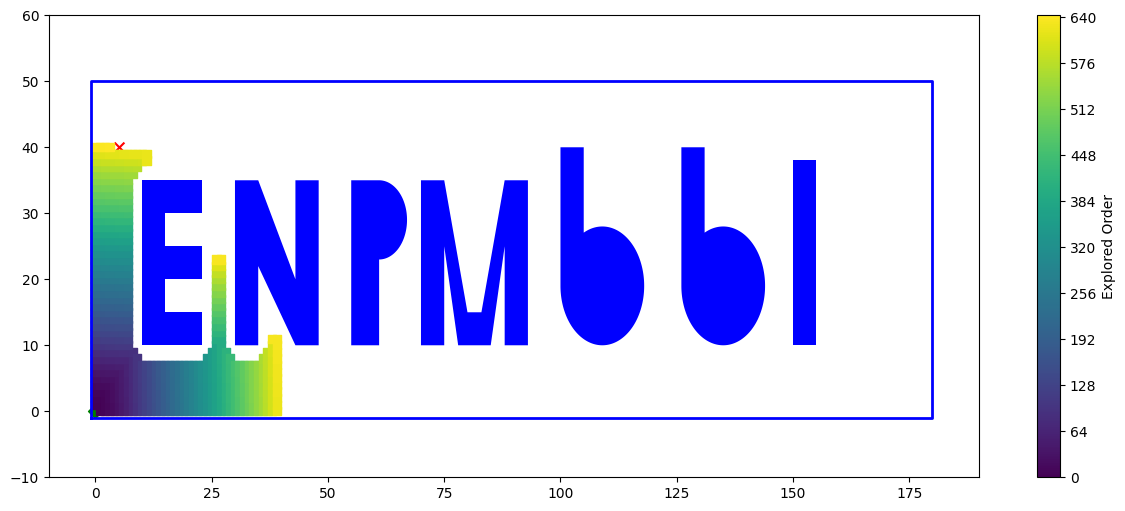

In [17]:
"""Breadth-First Seearch - Project 2

Erebus Oh

y
^
|
(0, 0) ----> x

"""

import matplotlib.pyplot as plt
import matplotlib.image
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

import numpy as np
from tqdm import tqdm

# We use the shapely library to help us create the obstacles and collision code
from shapely.geometry import Point, LinearRing
from shapely.geometry.polygon import Polygon
import shapely
from shapely import affinity

from typing import List, Tuple, Any, Union, Set
import math
import copy
from enum import Enum
import os
import queue
import time

CLEARANCE = 2
WIDTH = 180
HEIGHT = 50

BLUE = (0, 0, 255)
RED = (255, 0, 0)

# Step 1: Define Actions in Methematical Format
# Each state represented as the Node class
# Each action represented as enum and function

class Actions(Enum):
    # 8-connected space
    # .nam, .value
    # NAME = (DX, DY)
    UP = (0, 1)
    DOWN = (0, -1)
    LEFT = (-1, 0)
    RIGHT = (1, 0)

    UPLEFT = (-1, 1)
    UPRIGHT = (1, 1)
    DOWNLEFT = (-1, -1)
    DOWNRIGHT = (1, -1)

# Cost of each Action as a dictionary
COST_BFS = {
    Actions.UP: 1,
    Actions.DOWN: 1,
    Actions.LEFT: 1,
    Actions.RIGHT: 1,
    Actions.UPLEFT: 1,
    Actions.UPRIGHT: 1,
    Actions.DOWNLEFT: 1,
    Actions.DOWNRIGHT: 1
}

class Node:

    def __init__(self, pos: Tuple[int, int], index: int, parent: int):
        self.pos = pos
        self.index = index
        self.parent = parent

    def __copy__(self):
        # shallow copy
        return Node(pos = self.pos, index = self.index, parent = self.parent)
    
    def __deepcopy__(self, memo=None):
        # deep copy
        # ints copied by value
        return Node(pos = (self.pos[0], self.pos[1]), index = self.index, parent = self.parent)
    
    def __eq__(self, other: Any):
        # checks if robot position is the same
        # ignore index and parent info
        if isinstance(other, Node):
            return self.pos == other.pos
        else:
            return False
        
    def __hash__(self):
        # hash by robot position to use in Set
        return hash(str(self.pos))
    
    def __str__(self):
        return str(self.pos)
    
    def __repr__(self):
        return f"[pos={self.pos}, index={self.index}, parent={self.parent}]"
    
def in_bounds(coord: Tuple[int, int]) -> bool:
    # just checks if coordinate is within map bounds
    # will check if coordinate is an obstacle later
    x, y = coord
    x_in_bounds = x >= 0 and x < WIDTH
    y_in_bounds = y >= 0 and y < HEIGHT

    return x_in_bounds and y_in_bounds
    
def move(current_node: Node, dir: Actions) -> Node:

    if in_bounds(dir.value):
        dx, dy = dir.value
        next_node = copy.deepcopy(current_node)
        current_pos = current_node.pos
        next_node.pos = (current_pos[0] + dx, current_pos[1] + dy)
        next_node.parent = current_node.index
        # will update new node index later
        return next_node
    else:
        # invalid state
        return None
    
def move_up(current_node: Node) -> Node:
    return move(current_node, Actions.UP)

def move_down(current_node: Node) -> Node:
    return move(current_node, Actions.DOWN)

def move_left(current_node: Node) -> Node:
    return move(current_node, Actions.LEFT)

def move_right(current_node: Node) -> Node:
    return move(current_node, Actions.RIGHT)

def move_upleft(current_node: Node) -> Node:
    return move(current_node, Actions.UPLEFT)

def move_upright(current_node: Node) -> Node:
    return move(current_node, Actions.UPRIGHT)

def move_downleft(current_node: Node) -> Node:
    return move(current_node, Actions.DOWNLEFT)

def move_downright(current_node: Node) -> Node:
    return move(current_node, Actions.DOWNRIGHT)

ALL_ACTIONS = [
    move_up,
    move_down,
    move_left,
    move_right,
    move_upleft,
    move_upright,
    move_downleft,
    move_downright
]


# Step 2: Find the Mathematical Representation of Free Space
# We will be using the shapely library for drawing obstacle shapes
# and checking for collisions/clearance

class Obstacle():

    def __init__(
        self, 
        x_coords: List[int],
        y_coords: List[int], 
        xoffset: int = 0, 
        yoffset: int = 0, 
        clearance: int = 2
    ):
        # https://shapely.readthedocs.io/en/2.0.6/reference/shapely.LinearRing.html#shapely.LinearRing
        # https://shapely.readthedocs.io/en/2.0.6/reference/shapely.Polygon.html#shapely.Polygon
        self.boundary = LinearRing(np.vstack((x_coords, y_coords)).T)
        self.poly = Polygon(self.boundary)
        self.xoffset = xoffset
        self.yoffset = yoffset
        self.clearance = clearance
        # https://shapely.readthedocs.io/en/2.0.6/manual.html#shapely.affinity.translate
        self.poly = affinity.translate(self.poly,xoff=self.xoffset,yoff=self.yoffset)
        self.boundary = affinity.translate(self.boundary,xoff=self.xoffset,yoff=self.yoffset)

    def collides(self, coords) -> bool:
        p = Point(coords)
        
        # whether point is inside boundary (boundary exclusive)
        inside_obstacle = self.poly.contains(p)
        # https://shapely.readthedocs.io/en/2.0.6/reference/shapely.dwithin.html
        # whether point is +/- clearance from boundary
        within_clearance = self.boundary.dwithin(p, self.clearance)

        return inside_obstacle or within_clearance

    def draw(self, ax, color: str = 'blue'):
        ax.fill(*self.boundary.xy, facecolor=color)

# Obstacles

# Straight Letters/Numbers
class LetterE(Obstacle):
    x = [10, 10, 23, 23, 15, 15, 23, 23, 15, 15, 23, 23]
    y = [10, 35, 35, 30, 30, 25, 25, 20, 20, 15, 15, 10]

    def __init__(self):
        super().__init__(
            x_coords = self.x,
            y_coords = self.y,
            clearance = CLEARANCE
        )

class LetterN(Obstacle):
    x = [30, 30, 35, 43, 43, 48, 48, 43, 35, 35]
    y = [10, 35, 35, 20, 35, 35, 10, 10, 22, 10]

    def __init__(self):
        super().__init__(
            x_coords = self.x,
            y_coords = self.y,
            clearance = CLEARANCE
        )

class LetterM(Obstacle):
    x = [70, 70, 75, 80, 83, 88, 93, 93, 88, 88, 85, 78, 75, 75]
    y = [10, 35, 35, 15, 15, 35, 35, 10, 10, 25, 10, 10, 25, 10]

    def __init__(self):
        super().__init__(
            x_coords = self.x,
            y_coords = self.y,
            clearance = CLEARANCE
        )

class Number1(Obstacle):
    x = [150, 150, 155, 155]
    y = [10, 38, 38, 10]

    def __init__(self):
        super().__init__(
            x_coords = self.x,
            y_coords = self.y,
            clearance = CLEARANCE
        )

# Curved Letters/Numbers

def generate_arc(
    x_center, 
    y_center, 
    radius,
    start_theta,
    stop_theta,
    resolution = 1000
):
    # https://stackoverflow.com/questions/30762329/how-to-create-polygons-with-arcs-in-shapely-or-a-better-library
    
    thetas = np.radians(np.linspace(start_theta, stop_theta, resolution))
    x = x_center + radius * np.cos(thetas)
    y = y_center + radius * np.sin(thetas)

    return x, y

class LetterP(Obstacle):

    x1 = [55, 55, 61]
    y1 = [10, 35, 35]

    x_center = 61
    y_center = 29
    radius = 6
    start = 90
    stop = -90

    x2 = [61, 61]
    y2 = [23, 10]

    def __init__(self):

        cx, cy = generate_arc(
            x_center=self.x_center, 
            y_center=self.y_center, 
            radius=self.radius, 
            start_theta=self.start, 
            stop_theta=self.stop
        )

        x_coords = np.concatenate((self.x1, cx, self.x2))
        y_coords = np.concatenate((self.y1, cy, self.y2))

        super().__init__(
            x_coords=x_coords,
            y_coords=y_coords,
            clearance = CLEARANCE
        )

class Number6(Obstacle):

    x_center = 109
    y_center = 19
    radius = 9
    # 63.61 math.acos(4/9)
    start = 116.39
    stop = -180

    x1 = [100, 100, 105, 105]
    y_int = math.sqrt((radius ** 2) - ((105 - 109) ** 2)) + 19
    y1 = [19, 40, 40, y_int]

    def __init__(self, x_offset: int = 0, y_offset: int = 0):

        cx, cy = generate_arc(
            x_center=self.x_center, 
            y_center=self.y_center, 
            radius=self.radius, 
            start_theta=self.start, 
            stop_theta=self.stop
        )

        x_coords = np.concatenate((self.x1, cx))
        y_coords = np.concatenate((self.y1, cy))

        super().__init__(
            x_coords=x_coords,
            y_coords=y_coords,
            xoffset=x_offset,
            yoffset=y_offset,
            clearance = CLEARANCE
        )

class Project2Map:

    height = HEIGHT
    width = WIDTH

    map_filename = 'map.png'

    def __init__(self):
        self.obstacles = [
            LetterE(),
            LetterN(),
            LetterP(),
            LetterM(),
            Number6(),
            Number6(x_offset=26, y_offset=0),
            Number1(),
        ]

        if not os.path.exists(self.map_filename):
            # draw map space into image
            # only do on first run
            self.draw_map(show_fig=True, save = True)

        # load obstacle spaceback in
        # note: (0,0) upper right
        self._map_image = plt.imread(self.map_filename)
        

        

    def map(self, x: int, y: int):
        # returns False if obstacle, else True
        # assumes (0,0) bottom left
        # print(f"indexing: {-(y+1) + self.height}, {x}")
        pixel = self._map_image[-(y+1) + self.height, x][:-1].sum()
        return pixel == 0
    
    
    def draw_map(self, show_fig = False, save: bool = True):
        if show_fig:
            fig = plt.figure(figsize=(21, 6))
            ax = fig.add_subplot(111)
            ax.set_xlim(0, 180)
            ax.set_ylim(0, 50)
            # draw obstacles in blue
            for o in self.obstacles:
                o.draw(ax, color = 'blue')

        map_colors = np.zeros((self.height, self.width, 3))
        
        for i in tqdm(range(self.width), desc="Generating Map"):
            for j in range(self.height):
                # free space is green
                if show_fig:
                    ax.plot(i, j, marker='.', color='green')
                for o in self.obstacles:
                    if o.collides([i, j]):
                        # obstacle or clearance is red
                        if show_fig:
                            ax.plot(i, j, marker='.', color='red')
                        map_colors[-(j + 1) + self.height, i] = RED
                        continue
        if save:
            matplotlib.image.imsave(self.map_filename, map_colors/255.0)
            print(f"Saved map as {self.map_filename}")
        
        if show_fig:
            return fig, ax

# Step 3: Generate the Graph and Check for Goal Node in each Iteration
# aka perform BFS

class Project2Solver:

    def __init__(self, start, goal):
        # initializes map and obstacles
        self.map = Project2Map()

        # print welcome message

        # get start and goal positions from user input
        # start = self.get_input("Start")
        # goal = self.get_input("Goal")
        start = start
        goal = goal

        self.start = Node(start, 0, -1)
        self.goal = Node(goal, -1, -1)
        # nodes to explore
        self.open_list = queue.Queue()
        # explored nodes (in order of exploration)
        self.closed_list: List[Node] = []
        # visited nodes
        self.explored_order: List[Node] = []
        # explored notes as set
        # for efficient checking
        self.explored_set: Set[Node] = set()
        self.path: List[Node] = []

        # solve with BFS
        start = time.time()
        self.solve()
        stop = time.time()
        self.runtime = stop - start

        # visualize
        # self.visualize()

    def get_input(self, name: str) -> Tuple[int, int]:
        tup = ""
        while(isinstance(tup, str)):
            print(f"\t{tup}")
            tup = str(input(f"Enter {name} Position (e.g., X,Y): "))
            tup = self.str_to_tuple(tup)

            if not self.valid_coord(tup):
                tup = f"Invalid coordinates: {tup}"
        return tup

    def valid_coord(self, n: Node | Tuple[int, int]) -> bool:
        if isinstance(n, Node):
            n = n.pos
        
        within_bounds = in_bounds(n)
        if within_bounds:
            return self.map.map(n[0], n[1])

        return False

    def str_to_tuple(self, a: str) -> Tuple[int, int] | str:
        # returns properly parse coordinates, or string error message if input is invalid
        a_orig = copy.copy(a)
        # remove whitespace, and split by comma
        a = a.replace(' ', '')
        if a.find(',') < 0:
            # no comma found in string
            return f"No command found in input: {a}"
        # separate coordinates by comma
        a = a.split(',')
        if len(a) > 2:
            # more than x,y given
            return f"Too many coordinates found in input: {a_orig}"
        
        for num in a:
            if not num.isdigit():
                return f"Non-integer found in input: {a_orig} ({num})"

        # input properly formatted
        # return as tuple x,y
        return int(a[0]), int(a[1])   
    
    def solve(self) -> None:
        # Implement BFS

        # insert start in queue
        # print(self.start)
        # print(f"open list {self.open_list}")
        self.open_list.put(self.start)

        current = None

        # print(self.open_list)

        while self.open_list.qsize() > 0:

            # pop queue (FIFO)
            current = self.open_list.get()
            # print(current)
            # print(self.open_list)
            # print(self.closed_list)
            # add to closed list (visited)
            self.closed_list.append(current)
            self.explored_set.add(current)
            self.explored_order.append(current)

            # check if goal node
            if self.is_goal(current):
                # print(current)
                print("solved")
                break

            # generate all possible states from current state
            for action in ALL_ACTIONS:
                next = action(current)
                # check action is not into an obstacle
                # print(next)
                if (not next is None) and self.valid_coord(next) and (not next in self.explored_set):
                    # breakpoint()
                    # add to open list if not visited
                    # print(f"adding {next}")
                    next.parent = current.index
                    next.index = len(self.explored_order)
                    self.open_list.put(next)
                    self.explored_order.append(next)
                    self.explored_set.add(next)

            # failure if open list is empty
            if self.open_list.qsize() <= 0:
                raise RuntimeError(f"No solution for start: {self.start} and goal: {self.goal}")
        
        # current is goal
        # print(self.closed_list)
        # exit()
        self.path = self.generate_path(current)

        print(f"Solution: {len(self.path)}")
        # for p in self.path:
            # print(p)
    
    # Step 4: Optimal Path (Backtracking)
    # function to compaire current node with goal node
    # function to recreate path from start to goal node

    def is_goal(self, n: Node) -> bool:
        return self.goal == n
    
    def generate_path(self, final: Node) -> List[Node]:
        self.path = []
        while final != self.start:
            self.path.append(final)
            final = self.explored_order[final.parent]
        self.path.append(final)

        return self.path[::-1]



solver = Project2Solver(start=(0,0), goal=(5,40))


# Step 5: Represent the Optimal Path
# optimal path animations
# show node exploration and optimal path]

class Visualizer:

    def __init__(self, solver: Project2Solver):
        self.solver = solver
        self.np_closed = np.array([list(node.pos) for node in self.solver.closed_list])[1:-1]
        self.np_path = np.array([list(node.pos) for node in self.solver.path])[1:-1]

        self.fig, self.exploration_draw, self.path_line, self.cbar = self._init_frame()

        self.num_frames = self.np_closed.shape[0] + self.np_path.shape[0]

        self.gen_progress = None
        self.save_progress = None
        

    def _init_frame(self):
        # Create the figure and axes
        fig, ax = plt.subplots(figsize=(15, 6))
        ax.set_xlim(-10, 190)
        ax.set_ylim(-10, 60)

        # Draw borders
        border_x = [0-1, 0-1, 180, 180, 0-1]
        border_y = [0-1, 50, 50, 0-1, 0-1]
        ax.plot(border_x, border_y, linewidth=2, c='b')

        # Draw obstacles in blue
        for o in solver.map.obstacles:
            o.draw(ax, color='blue')

        # Draw start and goal
        ax.scatter(solver.start.pos[0], solver.start.pos[1], marker='D', c='g', s=50)
        ax.scatter(solver.goal.pos[0], solver.goal.pos[1], marker='x', c='r', s=50)

        # init exploration and path
        exploration_draw = ax.scatter([], [], marker='s', c=[], cmap='viridis')
        exploration_draw.set_clim(0, self.np_closed.shape[0])
        path_line, = ax.plot([], [], marker='s', linewidth=1, c='#ff29f8')

        # colorbar
        cstep = int(self.np_closed.shape[0] / 10) # want 10 ticks along colorbar
        cbar = fig.colorbar(exploration_draw, ax=ax)
        cbar.set_label('Explored Order')

        return fig, exploration_draw, path_line, cbar

    def _update_animation(self, i):
        if i < self.np_closed.shape[0]:
            self.exploration_draw.set_offsets(self.np_closed[:i])
            self.exploration_draw.set_array(np.arange(i))  # Update the color gradient

            self.cbar.set_ticks(np.arange(0, self.np_closed.shape[0], cstep))  # Adjust the ticks as the animation progresses
            self.cbar.set_label(f'Explored Order')  # Optionally update label

        elif self.np_closed.shape[0] < i:
            idx = i - (self.np_closed.shape[0] + num_pause_frames)
            self.path_line.set_data(self.np_path[:i])

        return self.exploration_draw, self.path_line,

    def _generate(self, i):
        self.gen_progress.update(1)
        return self._update_animation(i)
        

    def _save_update(self, i, total):
        self.save_progress.update(1)

    def animate(self):
        self.gen_progress = tqdm(total = self.num_frames, desc = "Generating Animation")
        ani = FuncAnimation(
            self.fig, 
            self._generate, 
            frames=self.num_frames, 
            interval=10, 
            blit=True, 
            repeat_delay=5000
        )
        self.save_progress = tqdm(total = self.num_frames, desc = "Saving Animation")
        ani.save(
            'animation.gif', 
            writer='pillow', 
            fps=60, 
            progress_callback=self._save_update
        )
        print("Done.")

v = Visualizer(solver)
v.animate()